## 先训练老师网络 

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data


torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [2]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        return output


def train_teacher(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_teacher(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)


In [3]:
def teacher_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = TeacherNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    teacher_history = []

    for epoch in range(1, epochs + 1):
        train_teacher(model, device, train_loader, optimizer, epoch)
        loss, acc = test_teacher(model, device, test_loader)
        
        teacher_history.append((loss, acc))

    torch.save(model.state_dict(), "teacher.pt")
    return model, teacher_history

In [4]:
# 训练教师网络

teacher_model, teacher_history = teacher_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0510, accuracy: 9832/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0364, accuracy: 9882/10000 (99%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0354, accuracy: 9883/10000 (99%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0325, accuracy: 9902/10000 (99%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0314, accuracy: 9897/10000 (99%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0330, accuracy: 9898/10000 (99%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0325, accuracy: 9908/10000 (99%)
Train 

## 小插曲，看看老师的暗知识 

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def softmax_t(x, t):
    x_exp = np.exp(x / t)
    return x_exp / np.sum(x_exp)

test_loader_bs1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

Output (NO softmax): [-31.14481   -30.600847   -3.2787514 -20.624037  -31.863455  -37.684086
 -35.177486  -22.72263   -16.028662  -26.460657 ]


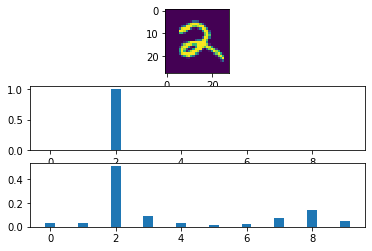

In [20]:
teacher_model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader_bs1))
    data, target = data.to('cuda'), target.to('cuda')
    output = teacher_model(data)

test_x = data.cpu().numpy()
y_out = output.cpu().numpy()
y_out = y_out[0, ::]
print('Output (NO softmax):', y_out)



plt.subplot(3, 1, 1)
plt.imshow(test_x[0, 0, ::])

plt.subplot(3, 1, 2)
plt.bar(list(range(10)), softmax_t(y_out, 1), width=0.3)

plt.subplot(3, 1, 3)
plt.bar(list(range(10)), softmax_t(y_out, 10), width=0.3)
plt.show()

# 让老师教学生网络 

In [9]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = F.relu(self.fc3(x))
        return output

### 关键，定义kd的loss 

In [21]:
def distillation(y, labels, teacher_scores, temp, alpha):
    return nn.KLDivLoss()(F.log_softmax(y / temp, dim=1), F.softmax(teacher_scores / temp, dim=1)) * (
            temp * temp * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)


In [15]:
def train_student_kd(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        teacher_output = teacher_model(data)
        teacher_output = teacher_output.detach()  # 切断老师网络的反向传播，感谢B站“淡淡的落”的提醒
        loss = distillation(output, target, teacher_output, temp=5.0, alpha=0.7)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student_kd(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [16]:
def student_kd_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    for epoch in range(1, epochs + 1):
        train_student_kd(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student_kd(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student_kd.pt")
    return model, student_history

In [17]:
student_kd_model, student_kd_history = student_kd_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1446, accuracy: 9705/10000 (97%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1195, accuracy: 9739/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0880, accuracy: 9799/10000 (98%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0725, accuracy: 9825/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0753, accuracy: 9831/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0711, accuracy: 9846/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0691, accuracy: 9837/10000 (98%)
Train 

In [18]:
## 让学生自己学，不使用KD
def train_student(model, device, train_loader, optimizer, epoch):
    model.train()
    trained_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        trained_samples += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, trained_samples, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')


def test_student(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [19]:
def student_main():
    epochs = 10
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = StudentNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    student_history = []
    
    for epoch in range(1, epochs + 1):
        train_student(model, device, train_loader, optimizer, epoch)
        loss, acc = test_student(model, device, test_loader)
        student_history.append((loss, acc))

    torch.save(model.state_dict(), "student.pt")
    return model, student_history

In [20]:
student_simple_model, student_simple_history = student_main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1245, accuracy: 9627/10000 (96%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0980, accuracy: 9717/10000 (97%)
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1002, accuracy: 9726/10000 (97%)
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0838, accuracy: 9774/10000 (98%)
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1062, accuracy: 9760/10000 (98%)
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0989, accuracy: 9789/10000 (98%)
Train epoch 7: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.1106, accuracy: 9756/10000 (98%)
Train 

In [21]:
import matplotlib.pyplot as plt

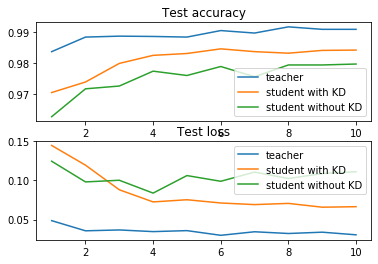

In [23]:
epochs = 10
x = list(range(1, epochs+1))

plt.subplot(2, 1, 1)
plt.plot(x, [teacher_history[i][1] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][1] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][1] for i in range(epochs)], label='student without KD')

plt.title('Test accuracy')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(x, [teacher_history[i][0] for i in range(epochs)], label='teacher')
plt.plot(x, [student_kd_history[i][0] for i in range(epochs)], label='student with KD')
plt.plot(x, [student_simple_history[i][0] for i in range(epochs)], label='student without KD')

plt.title('Test loss')
plt.legend()


